Name: Salvatore Caruso

Collaborators: Nicholas Nolan

In [1]:
#Question 1a

import math
import numpy
import matplotlib.pyplot as plt
import tarfile
from scipy.stats import pearsonr
import statistics
import pandas as pd
import scipy.io as scy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sknetwork.clustering import Louvain
from sklearn.neighbors import NearestNeighbors
import seaborn as sb
import anndata as ad
import scanpy as sc
from sklearn.cluster import KMeans

In [2]:
#opening files
genes_tsv = "filtered_gene_bc_matrices/GRCh38/genes.tsv"
cells_tsv = "filtered_gene_bc_matrices/GRCh38/barcodes.tsv"
genes = pd.read_csv(genes_tsv,sep = '\t')
cells = pd.read_csv(cells_tsv,sep = '\t')
genes_list = genes[genes.columns[1]].tolist()
genes_list = ['RP11-34P13.3'] + genes_list

raw_data = tarfile.open("t_4k_filtered_gene_bc_matrices.tar.gz", "r:gz")
raw_data.extractall()
raw_matrix = scy.mmread("filtered_gene_bc_matrices/GRCh38/matrix.mtx")
dense_matrix = raw_matrix.todense()

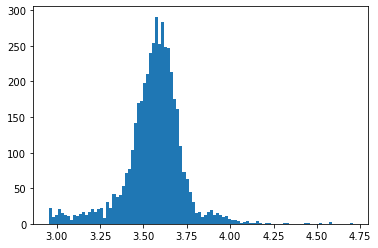

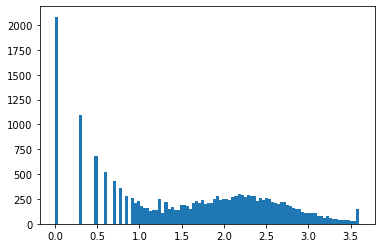

In [3]:
#Generating Histograms to determine cell and gene cutoffs 

#eliminating undetected genes
intermediate_dense = numpy.delete(dense_matrix, numpy.where(numpy.sum(dense_matrix, axis =1) == 0), axis = 0)

#eliminating undetected cells
final_dense = numpy.delete(intermediate_dense, numpy.where(numpy.sum(intermediate_dense, axis =0) == 0), axis = 1)

#Screening out Noise
sum_cells = numpy.sum(dense_matrix, axis = 0)
log_10_cells = numpy.log10(sum_cells)
list_log = log_10_cells.tolist()
plt.hist(list_log,bins = 100)
plt.show()

#Screening out cells below 10^(3.4)
screened_matrix = numpy.delete(dense_matrix, numpy.where(numpy.sum(dense_matrix, axis = 0) < 10**3.4), axis = 1)

#Screening out Empty Genes
total_genes = numpy.sum(screened_matrix, axis = 1)
intermediate_screened_matrix = numpy.delete(screened_matrix, numpy.where(total_genes == 0), axis=0)

#binarize matrix and then take log value of genes
binarize_matrix = numpy.where(intermediate_screened_matrix > 0, 1, 0)
sum_binarize_matrix = numpy.sum(binarize_matrix, axis = 1)
log_10_genes = numpy.log10(sum_binarize_matrix)
list_log_genes = log_10_genes.tolist()
plt.hist(list_log_genes,bins = 100)
plt.show()

#screening out genes below 10^(1.3)
final_screened_matrix = numpy.delete(intermediate_screened_matrix, numpy.where(numpy.sum(binarize_matrix,axis =1) < 10**1.3), axis = 0)


         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'gene_names' as categorical


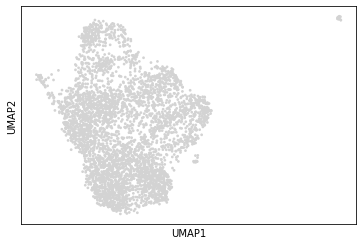

In [4]:
#Converting to AnnData Matrix and screening out based on cutoffs determined from Histograms
raw_data_AD = sc.AnnData(X = dense_matrix)
raw_data_AD.obs['gene_names'] = genes_list
raw_data_AD.obs_names = raw_data_AD.obs['gene_names']
raw_data_AD.obs_names_make_unique(join='-')
raw_data_trans = raw_data_AD.transpose()
sc.pp.filter_cells(raw_data_trans, min_counts=(10**3.4))
sc.pp.filter_genes(raw_data_trans, min_counts=(10**1.3))
sc.pp.normalize_total(raw_data_trans)
sc.pp.log1p(raw_data_trans)

#UMAP Analysis and plotting
sc.pp.neighbors(raw_data_trans, n_neighbors=30)
UMAP_output = sc.tl.umap(raw_data_trans)
sc.pl.umap(raw_data_trans)

Question 1b

Looking at the tSNE plot alone, we would conclude that there is no significant clustering that would strongly indicate that the heterogeneity witnessed is due to cell types alone. Thus, we look to determine if it is from cell trajectories.

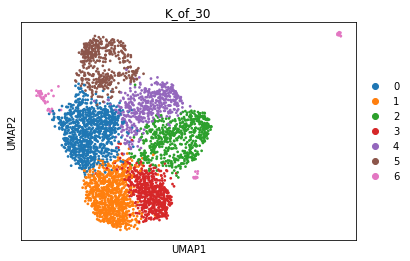

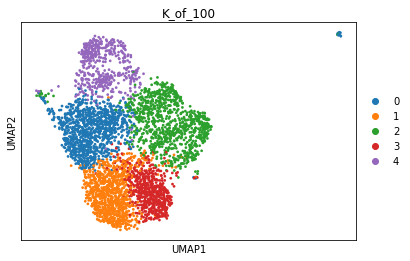

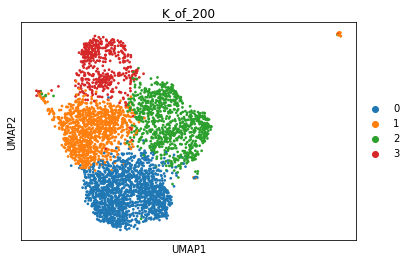

In [5]:
#Question 1C

#Plotting 30-NN
sc.pp.neighbors(raw_data_trans, n_neighbors=30)
sc.tl.louvain(raw_data_trans, key_added="K_of_30")
sc.pl.umap(raw_data_trans, color=['K_of_30'])

#Plotting 50-NN
sc.pp.neighbors(raw_data_trans, n_neighbors=100)
sc.tl.louvain(raw_data_trans, key_added="K_of_100")
sc.pl.umap(raw_data_trans, color=['K_of_100'])

#Plotting 70-NN
sc.pp.neighbors(raw_data_trans, n_neighbors=200)
sc.tl.louvain(raw_data_trans, key_added="K_of_200")
sc.pl.umap(raw_data_trans, color=['K_of_200'])


As we would expect, increasing k in the nearest neighbors clustering method results in a reduction of finer clusters and thus a reduction in the overall number of clusters identified.


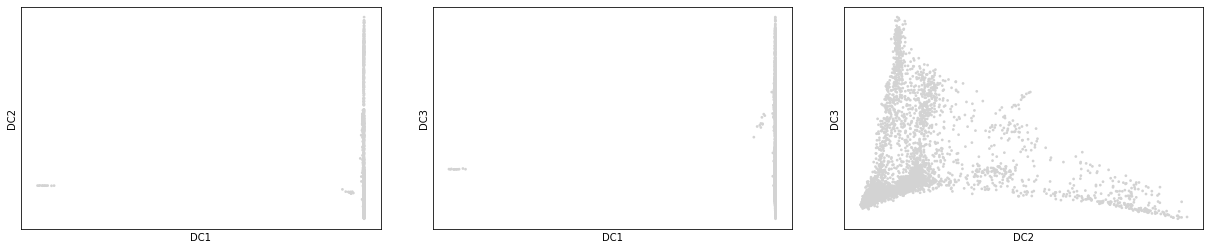

[1.         0.9957687  0.97880924 0.9609626  0.9514086  0.94391894
 0.91395193 0.911275   0.90132457 0.87906384 0.8710251  0.8590964
 0.84642106 0.8425801  0.8360423 ]


In [6]:
#Question 2a
sc.pp.neighbors(raw_data_trans)
sc.tl.diffmap(raw_data_trans)
sc.pl.diffmap(raw_data_trans, components=['1,2','1,3','2,3'])

X_diffmap = raw_data_trans.obsm['X_diffmap']

eigen_values = raw_data_trans.uns['diffmap_evals']
print(eigen_values)

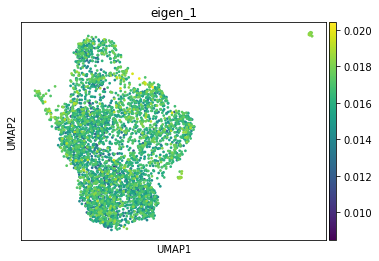

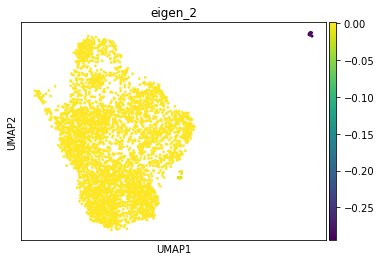

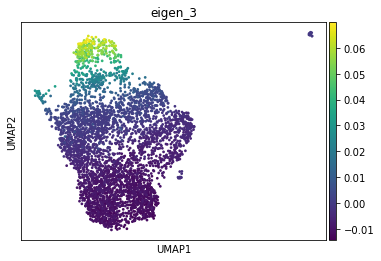

In [7]:
#Question 2b
raw_data_trans.obs['eigen_1'] = X_diffmap[:,0]
raw_data_trans.obs['eigen_2'] = X_diffmap[:,1]
raw_data_trans.obs['eigen_3'] = X_diffmap[:,2]

sc.pl.umap(raw_data_trans, color = ['eigen_1'])
sc.pl.umap(raw_data_trans, color = ['eigen_2'])
sc.pl.umap(raw_data_trans, color = ['eigen_3'])

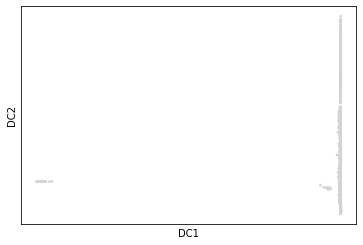

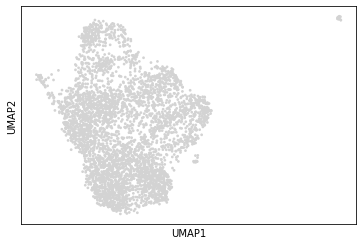

In [8]:
#Question 2C
sc.pl.diffmap(raw_data_trans, components=['1,2'])
sc.pl.umap(raw_data_trans)

Compared to the tSNE map, we clearly lose the clustering that we had before, but gain a heightened display of the transitions going on within our data as shown by the clearly defined behavior in the diffusion map

In [11]:
#Question 2D

#Generating Pearson's Correlation List and annotating matrix
pearson_list = []
for i in range(1,11412):
    pearson_corr, _ = pearsonr(raw_data_trans.X[:,i-1],X_diffmap[:,1])
    pearson_list.append(pearson_corr)

#annotating coefficients and printing top 10 genes
raw_data_trans.var['pearson_coeffs'] = pearson_list
top_10_genes = raw_data_trans.var['gene_names'][raw_data_trans.var['pearson_coeffs'].argsort()[:10]]
print(top_10_genes.tolist())

['CPVL', 'LYZ', 'LGALS2', 'CST3', 'CLEC7A', 'SPI1', 'MPEG1', 'BATF3', 'WDFY4', 'RAB31']


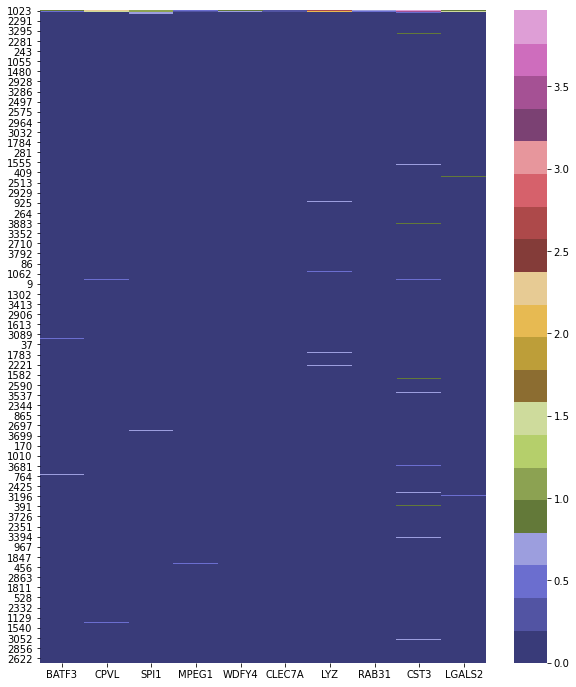

In [12]:
#Question 2E
top_genes_matrix = raw_data_trans[:,raw_data_trans.var_names.isin(top_10_genes.tolist())]
panda_transfer = pd.DataFrame(data = top_genes_matrix.X, columns = top_genes_matrix.var['gene_names'].tolist())
diff_comp_list = top_genes_matrix.obs['eigen_2'].tolist()
panda_transfer['Diffusion_Comp'] = diff_comp_list
panda_sorted = panda_transfer.sort_values(by = ['Diffusion_Comp'])
panda_final = panda_sorted.drop(columns = ['Diffusion_Comp'])

figure = plt.subplots(figsize = (10,12))
sb.heatmap(panda_final,cmap = 'tab20b')

In [9]:
#Question 2f Using Diffusion Component 3

#Generating Pearson's Correlation List and annotating matrix
pearson_list_2 = []
for i in range(1,11412):
    pearson_corr_2, _ = pearsonr(raw_data_trans.X[:,i-1],X_diffmap[:,2])
    pearson_list_2.append(pearson_corr_2)

#annotating coefficients and printing top 10 genes
raw_data_trans.var['pearson_coeffs_2'] = pearson_list_2
top_10_genes_2 = raw_data_trans.var['gene_names'][raw_data_trans.var['pearson_coeffs_2'].argsort()[:10]]
print(top_10_genes_2.tolist())

['RPL32', 'RPL13', 'RPL34', 'RPS3A', 'RPS6', 'RPS13', 'RPL11', 'RPS23', 'RPL39', 'RPS12']


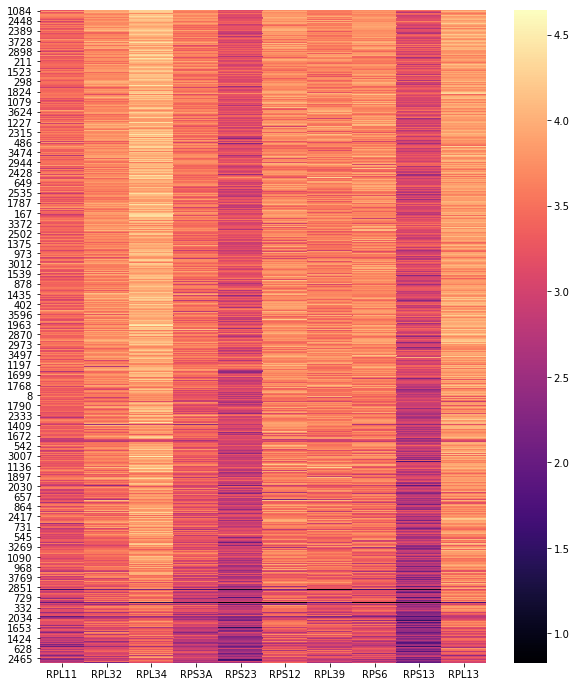

In [10]:
top_genes_matrix_2 = raw_data_trans[:,raw_data_trans.var_names.isin(top_10_genes_2.tolist())]
panda_transfer_2 = pd.DataFrame(data = top_genes_matrix_2.X, columns = top_genes_matrix_2.var['gene_names'].tolist())
diff_comp_list_2 = top_genes_matrix_2.obs['eigen_3'].tolist()
panda_transfer_2['Diffusion_Comp'] = diff_comp_list_2
panda_sorted_2 = panda_transfer_2.sort_values(by = ['Diffusion_Comp'])
panda_final_2 = panda_sorted_2.drop(columns = ['Diffusion_Comp'])

figure = plt.subplots(figsize = (10,12))
sb.heatmap(panda_final_2, cmap = 'magma')

In [13]:
#2g for DC 2

#Generating Pearson's Correlation List and annotating matrix
pearson_list_3 = []
for i in range(1,11412):
    pearson_corr_3, _ = pearsonr(raw_data_trans.X[:,i-1],X_diffmap[:,1])
    pearson_list_3.append(pearson_corr_3)

#annotating coefficients and printing top 10 genes
raw_data_trans.var['pearson_coeffs_3'] = pearson_list_3
worst_10_genes = raw_data_trans.var['gene_names'][raw_data_trans.var['pearson_coeffs_3'].argsort()[-10:]]
print(worst_10_genes.to_list())

['RPS15A', 'RPL30', 'RPL3', 'RPS3', 'RPLP2', 'RPL13', 'RPL34', 'RPS29', 'RPS27A', 'RPS27']


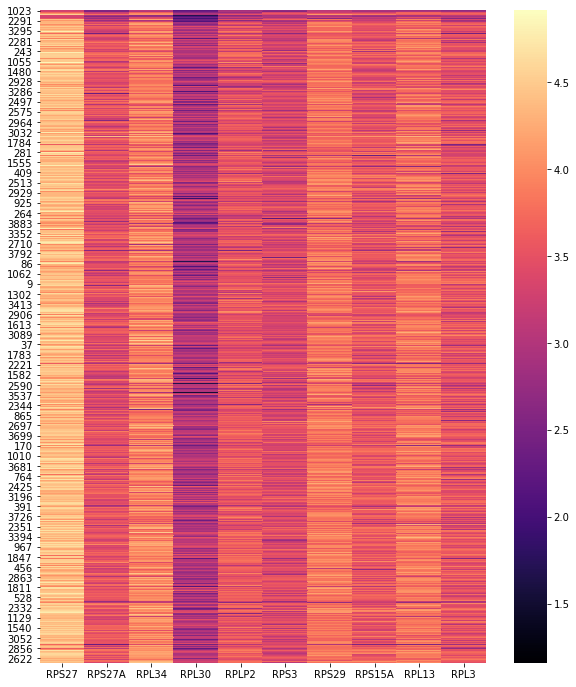

In [14]:
worst_genes_matrix = raw_data_trans[:,raw_data_trans.var_names.isin(worst_10_genes.tolist())]
panda_transfer_3 = pd.DataFrame(data = worst_genes_matrix.X, columns = worst_genes_matrix.var['gene_names'].tolist())
diff_comp_list_3 = worst_genes_matrix.obs['eigen_2'].tolist()
panda_transfer_3['Diffusion_Comp'] = diff_comp_list_3
panda_sorted_3 = panda_transfer_3.sort_values(by = ['Diffusion_Comp'])
panda_final_3 = panda_sorted_3.drop(columns = ['Diffusion_Comp'])

figure = plt.subplots(figsize = (10,12))
sb.heatmap(panda_final_3, cmap = 'magma')

In [15]:
#2g for DC 3

#Generating Pearson's Correlation List and annotating matrix
pearson_list_4 = []
for i in range(1,11412):
    pearson_corr_4, _ = pearsonr(raw_data_trans.X[:,i-1],X_diffmap[:,2])
    pearson_list_4.append(pearson_corr_4)

#annotating coefficients and printing top 10 genes
raw_data_trans.var['pearson_coeffs_4'] = pearson_list_4
worst_10_genes_2 = raw_data_trans.var['gene_names'][raw_data_trans.var['pearson_coeffs_4'].argsort()[-10:]]
print(worst_10_genes_2.tolist())

['B2M', 'GZMB', 'CCL4', 'FGFBP2', 'GZMA', 'CST7', 'CCL5', 'GZMH', 'GNLY', 'NKG7']


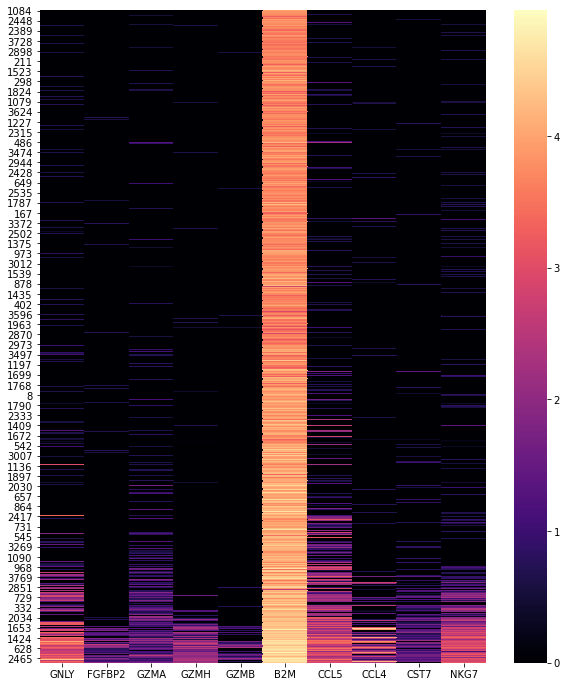

In [16]:
worst_genes_matrix_2 = raw_data_trans[:,raw_data_trans.var_names.isin(worst_10_genes_2.tolist())]
panda_transfer_4 = pd.DataFrame(data = worst_genes_matrix_2.X, columns = worst_genes_matrix_2.var['gene_names'].tolist())
diff_comp_list_4 = worst_genes_matrix.obs['eigen_3'].tolist()
panda_transfer_4['Diffusion_Comp'] = diff_comp_list_4
panda_sorted_4 = panda_transfer_4.sort_values(by = ['Diffusion_Comp'])
panda_final_4 = panda_sorted_4.drop(columns = ['Diffusion_Comp'])

figure = plt.subplots(figsize = (10,12))
sb.heatmap(panda_final_4, cmap = 'magma')

Based on the results, I would characterize component 2 as having a high degree of correlation to multiple genes, where as when using component 3, we only see selective correlation of this component with a handful of genes.

Question 3:

One project idea that was interesting to our team, was how RNA-seq output would change in response to gene therapy, specifically in the retina.To execute this project, we would require data from pre- and post- treatment groups. Ideally, the model we construct would be able to validate the therapy itself, and identify off-target shifts in metabolite profiles or genes being expressed in patients examined. It may be difficult to find this data directly from our lab as we cannot use unpublished information and are not sure of data collection techniques utilized by our lab in regards to RNA-seq. Overall, this would be a nice bridge between our work in the lab and class. We are not sure of the cloud computing resources that would be required, as they highly depend on the size of the dataset.